In [4]:
'''
@author     : Ali Mustofa HALOTEC
@module     : Vehicle Classification Jetson Interface
@Created on : 13 Sept 2021
'''

import cv2
import sys
import numpy as np
from PIL import Image

import jetson.inference as jetson_interface
import jetson.utils as jetson_utils

sys.path.append("..")
from config import CLASESS_MODEL_SSDNET, VEHICLE_CLASESS

In [31]:
class VehicleClassification:
    def __init__(self):
        self.network    = 'ssd-mobilenet-v2'
        self.overlay    = 'box, labels, conf'
        self.threshold  = 0.4
        self.model      = jetson_interface.detectNet(self.network, threshold=self.threshold)

    def __np_image2_cuda_image(self, image):
        return jetson_utils.cudaFromNumpy(image)

    def filter_and_crop(self, results, min_confidence=0.0):
        '''
        Format result(
        -- ClassID: int()
        -- Confidence: float()
        -- Left:    float()
        -- Top:     float()
        -- Right:   float()
        -- Bottom:  float()
        -- Width:   float()
        -- Height:  float()
        -- Area:    float()
        -- Center:  tuple(float(), float())
        )
        Filter min confidence prediction and classes id/name
        Cropped image and get index max value confidence lavel
        Args:
            results(jetson.inference.detectNet.Detection) : results prediction ssd-mobilenet-v2
            min_confidence(float(range 0.0 - 1.0)) : minimal confidence for filter results
        Return:
            result(tuple) : (confidence, bbox, clases_name)
        '''
        min_confidence = 0.4
        max_conf, bbox, clases = 0.0, list(), str()

        if len(results) >= 1:
            for result in results:
                classes_name    = CLASESS_MODEL_SSDNET[int(result.ClassID)]
                confidence      = result.Confidence
                if classes_name in VEHICLE_CLASESS and confidence > min_confidence:
                    max_conf        = confidence
                    x_min, y_min    = int(result.Left), int(result.Top)
                    x_max, y_max    = int(result.Right), int(result.Bottom)
                    bbox, clases    = [x_min, y_min, x_max, y_max], classes_name
                else:
                    max_conf 	= max_conf
                    bbox		= bbox
                    clases		= clases
        else : max_conf, bbox, clases = 0.0, list(), str()

        vehicles_classification = (max_conf, bbox, clases)
        return vehicles_classification

    def detection(self, image):
        '''
        Detection image with ssd-mobilenet-v2
        -> convert image(np.array) to CudaImage
        -> Detection 
        Args:
            img(np.array): image for prediction,
        Retrun:
            result(list): result detection ssd-mobilenet-v2(<jetson.inference.detectNet.Detection object at 0x7f9be9f090>)
        '''
        cuda_image = self.__np_image2_cuda_image(image)
        results = self.model.Detect(cuda_image, overlay=self.overlay)
        return results

In [32]:
classification = VehicleClassification()

In [36]:
image = cv2.imread('capture_rec_1.jpg')
results_classification = classification.detection(image)
vehicle_type = classification.filter_and_crop(
		results=results_classification, min_confidence=0.4
)
vehicle_type

(0.4335017502307892, [910, 458, 1197, 638], 'car')

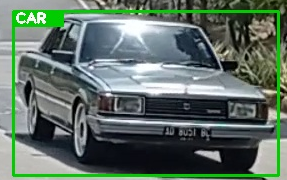

In [37]:
crop_image = image[vehicle_type[1][1]:vehicle_type[1][3], vehicle_type[1][0]: vehicle_type[1][2]]
Image.fromarray(cv2.cvtColor(crop_image, cv2.COLOR_BGR2RGB))